<a href="https://colab.research.google.com/github/ckkissane/deep_learning_curriculum/blob/master/solutions/8_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a small CNN to do MNIST classification, and try your best to mechanistically understand how it is able to classify digits correctly.

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(3407)

In [3]:
batch_size = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                          download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
#Defining the small CNN
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

        self.num_params = sum(p.numel() for p in self.parameters())
        print(f"num params: {self.num_params}")

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return x
    
    def forward_activations(self, x):
        conv = self.conv1(x)
        maxpool = F.max_pool2d(conv, 3)
        relu = F.relu(maxpool)
        flatten = relu.view(-1, 192)
        fc = self.fc(flatten)
        acts = {'conv': conv, 'maxpool': maxpool, 'relu': relu, 'flatten': flatten, 'fc': fc}
        return acts

In [6]:
model = ConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

num params: 1960


In [7]:
def train(model, optimizer):
    model.train()
    print(f"training model with {model.num_params} parameters")
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for it, (images, labels) in pbar:  
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
            
        loss.backward()
        optimizer.step()

        pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")

train(model, optimizer)

training model with 1960 parameters


iter 468: train loss 0.18149: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]


In [8]:
# sanity check it actually learned stuff
def test(model):
    model.eval()
    print(f"testing model with {model.num_params} parameters")
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            test_loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader)
        print(f"test loss: {test_loss}")
        print(f"Accuracy of the network on the 10000 test images: {correct / total}")
        return test_loss, correct / total

test(model)

testing model with 1960 parameters
test loss: 0.13905100826221176
Accuracy of the network on the 10000 test images: 0.9577


(0.13905100826221176, 0.9577)

# Try feature visualization, but note that it often doesn't work for models trained on such a simple dataset.

I'll start by trying to create an img to maximize some class output score, as that should intuitively be the easiest

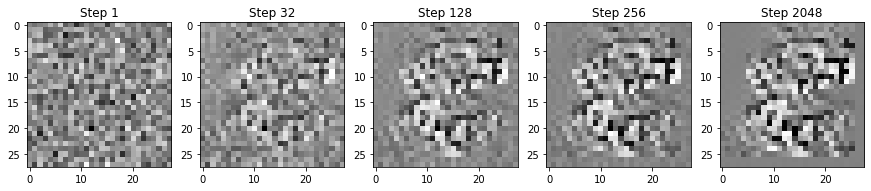

In [9]:
def optimize_logit(label):
    img = torch.randn(1, 28, 28).to(device)
    img.requires_grad = True
    feature_optimizer = torch.optim.Adam([img], lr=0.05)
    
    num_iters = 2560
    images = [img.clone()]
    for it in range(num_iters):
        acts = model.forward_activations(img)
        logits = acts['fc']
        score = logits.squeeze()[label]
        feature_optimizer.zero_grad()
        loss = -score + torch.linalg.norm(img.squeeze(), ord=2)
        loss.backward()
        feature_optimizer.step()
        images.append(img.clone())
    
    steps_to_show = [1, 32, 128, 256, 2048]
    fig, axs = plt.subplots(1, len(steps_to_show), figsize=(15, 6))
    for i, step in enumerate(steps_to_show):
        axs[i].imshow(images[step].squeeze(0).detach().cpu().numpy(), cmap='gray', interpolation=None)
        axs[i].set_title("Step " + str(step))
    plt.show()
    
optimize_logit(8)

Now to try to maximize the value of a single activation after the conv layer

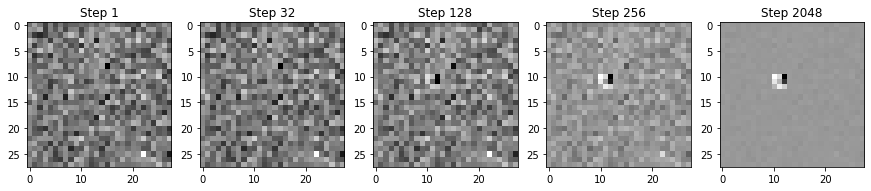

In [10]:
def optimize_neuron(channel_idx, neuron_x, neuron_y):
    img = torch.randn(1, 28, 28).to(device)
    img.requires_grad = True
    feature_optimizer = torch.optim.SGD([img], lr=0.05)
    num_iters = 2560

    images = [img.clone()]
    for it in range(num_iters):
        acts = model.forward_activations(img)
        after_conv = acts['conv']
        feature_optimizer.zero_grad()
        loss = -after_conv[channel_idx, neuron_x, neuron_y]
        loss.backward()
        feature_optimizer.step()
        images.append(img.clone())

    steps_to_show = [1, 32, 128, 256, 2048]
    fig, axs = plt.subplots(1, len(steps_to_show), figsize=(15, 6))
    for i, step in enumerate(steps_to_show):
        axs[i].imshow(images[step].squeeze(0).detach().cpu().numpy(), cmap='gray', interpolation=None)
        axs[i].set_title("Step " + str(step))
    plt.show()

optimize_neuron(channel_idx=0, neuron_x=10, neuron_y=10)

This isn't super helpful. It only looks at the 3x3 area of pixels where the convolution operation maps to position (neuron_x, neuron_y) in the corresponding output channel. It will basically learn the conv filter itself.

Next i'll try to maximize activations of an entire channel

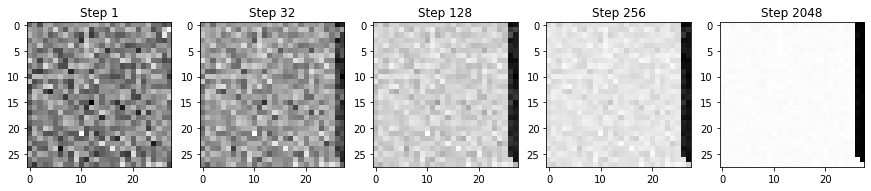

In [11]:
def optimize_channel(channel_idx):
    img = torch.randn(1, 28, 28).to(device)
    img.requires_grad = True
    feature_optimizer = torch.optim.Adam([img], lr=0.05)
    
    num_iters = 2560
    images = [img.clone()]
    for it in range(num_iters):
        acts = model.forward_activations(img)
        after_conv = acts['conv']
        feature_optimizer.zero_grad()
        loss = -after_conv[channel_idx].sum() + torch.linalg.norm(img.squeeze(), ord=2)
        loss.backward()
        feature_optimizer.step()
        images.append(img.clone())
    
    steps_to_show = [1, 32, 128, 256, 2048]
    fig, axs = plt.subplots(1, len(steps_to_show), figsize=(15, 6))
    for i, step in enumerate(steps_to_show):
        axs[i].imshow(images[step].squeeze(0).detach().cpu().numpy(), cmap='gray', interpolation=None)
        axs[i].set_title("Step " + str(step))
    plt.show()
    
optimize_channel(0)

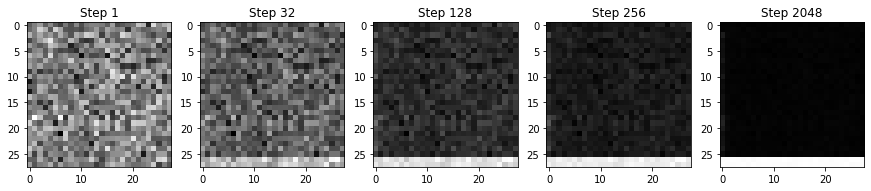

In [12]:
optimize_channel(1)

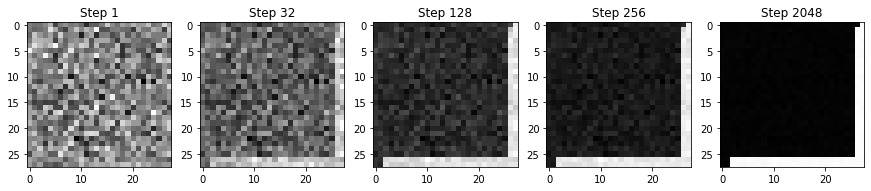

In [13]:
optimize_channel(2)

This doesn't seem super useful... so I'm wondering if I have a bug or I'm misunderstanding how it's supposed to work. I think it's essentially a bunch of the conv filters overlapped, which kind of makes sense (since these maximize individual neuron activations).

We can also try direct dataset examples to see what activates different channels

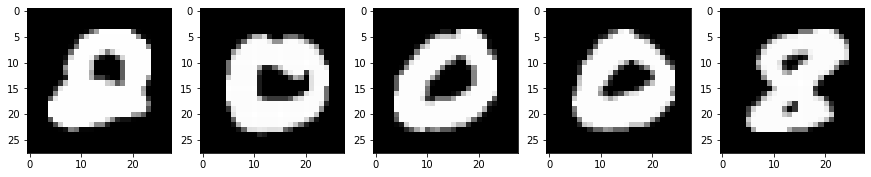

In [14]:
def get_dataset_ex_channel(channel_idx):
    activations = []
    for it, (img, label) in enumerate(test_dataset):
        img = img.to(device)
        acts = model.forward_activations(img)
        after_conv = acts['conv']
        loss = -after_conv[channel_idx].sum()
        activations.append((loss.item(), img))
    
    activations.sort(key=lambda x: x[0])

    num_to_plot = 5
    fig, axs = plt.subplots(1, num_to_plot, figsize=(15, 6))
    for i, (loss, img) in enumerate(activations[:num_to_plot]):
        axs[i].imshow(img.squeeze(0).detach().cpu().numpy(), cmap='gray', interpolation=None)
    plt.show()

get_dataset_ex_channel(0)

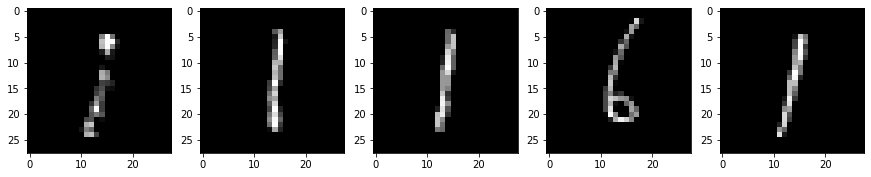

In [15]:
get_dataset_ex_channel(1)

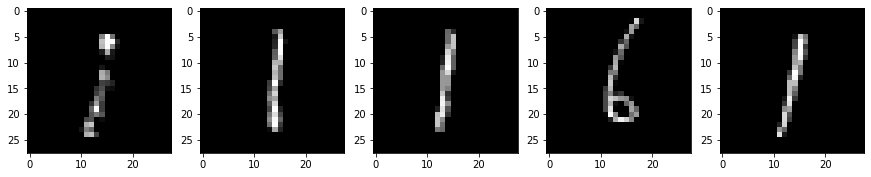

In [16]:
get_dataset_ex_channel(2)

It sort of matches the optimized examples... 

Overall feature visualization doesn't seem super useful to interpret what the conv layers are learning here. In the future it could be good to try more advanced regularization techniques from the distill post, or try these on a deeper network.

# Try attribution, which is more likely to help.

Start with simple saliency maps

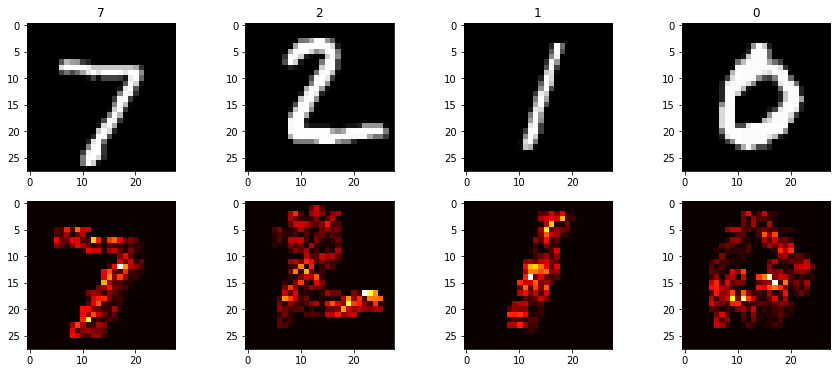

In [17]:
def saliency_logits(num_maps):
    fig, axs = plt.subplots(2, num_maps, figsize=(15, 6))
    for i, (img, label) in enumerate(test_dataset):
        img = img.to(device)
        img.requires_grad = True
        acts = model.forward_activations(img)
        logits = acts['fc']
        score = logits.squeeze()[label]
        score.backward()
        axs[0][i].imshow(img.detach().squeeze().cpu(), cmap='gray')
        axs[1][i].imshow(img.grad.squeeze().abs().cpu(), cmap=plt.cm.hot)
        axs[0][i].set_title(label)
        if i == num_maps - 1:
            break
    plt.show()

saliency_logits(num_maps=4)

Nothing super surprising here... the white pixels that represent the digit have the most impact in determining the class output score. Let's try to do the same but see what activates a neuron (or cluster of neurons) for the first conv layer

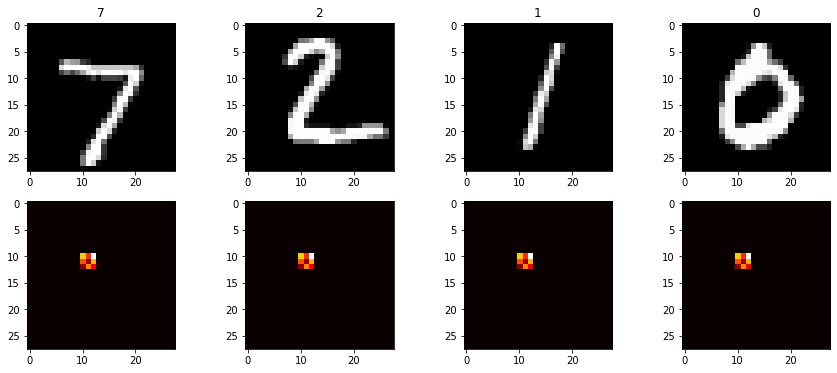

In [65]:
def saliency_conv_neuron(channel_idx, neuron_x, neuron_y):
    num_maps = 4
    fig, axs = plt.subplots(2, num_maps, figsize=(15, 6))
    for i, (img, label) in enumerate(test_dataset):
        img = img.to(device)
        img.requires_grad = True
        acts = model.forward_activations(img)
        conv_act = acts['conv']
        score = conv_act[channel_idx, neuron_x, neuron_y]
        score.backward()
        axs[0][i].imshow(img.detach().squeeze().cpu(), cmap='gray')
        axs[1][i].imshow(img.grad.squeeze().abs().cpu(), cmap=plt.cm.hot)
        axs[0][i].set_title(label)
        if i == num_maps - 1:
            break
    plt.show()

saliency_conv_neuron(0, 10, 10)

Similar to above, this isn't interesting since Only a small 3x3 pixel area determines the value of that activation. 

I'll try the same thing for activations of entire channel

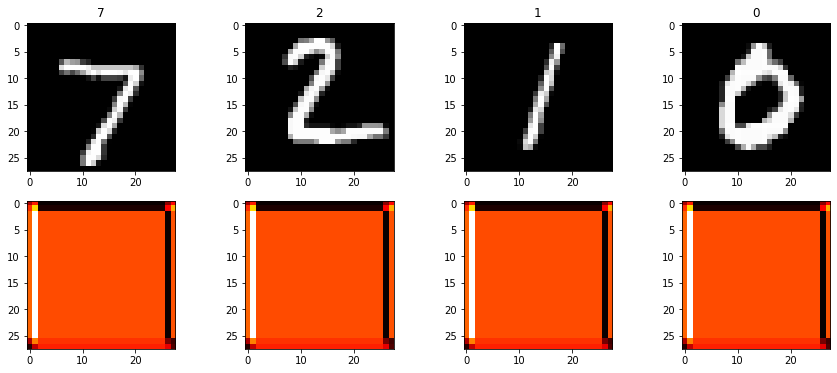

In [66]:
def saliency_conv_channel(channel_idx):
    num_maps = 4
    fig, axs = plt.subplots(2, num_maps, figsize=(15, 6))
    for i, (img, label) in enumerate(test_dataset):
        img = img.to(device)
        img.requires_grad = True
        acts = model.forward_activations(img)
        conv_act = acts['conv']
        score = conv_act[channel_idx].sum()
        score.backward()
        axs[0][i].imshow(img.detach().squeeze().cpu(), cmap='gray')
        axs[1][i].imshow(img.grad.squeeze().abs().cpu(), cmap=plt.cm.hot)
        axs[0][i].set_title(label)
        if i == num_maps - 1:
            break
    plt.show()

saliency_conv_channel(0)

Hmm it seems fishy that all the saliency maps here looks identical. I might have a bug?

# Use whatever other techniques you like. Consider focusing in on a small part of the network and trying to understand it as best you can.

First I'll just look at the weights of the conv filters to get insight on what they're looking for.

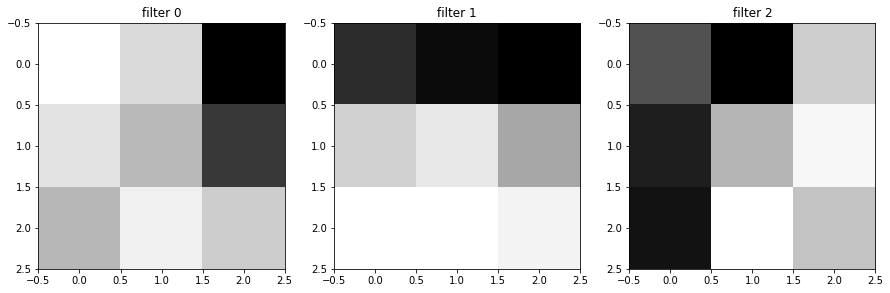

In [58]:
conv_filters = model.state_dict()['conv1.weight']
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for i in range(3):
    axs[i].imshow(conv_filters[i].squeeze().cpu(), cmap='gray')
    axs[i].set_title("filter " + str(i))

They are very simple, and we can try to interpret them:
* filter 0 looks for the right edge of diagonals
* filter 1 looks like a top edge detector
* filter 2 looks for the left edge of diagonals

To confirm this interpretation I'll visualize the activations after the conv layer

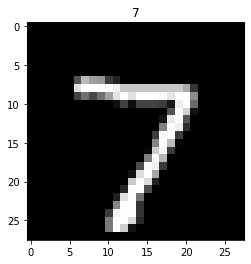

In [46]:
img, label = test_dataset[0]
img = img.to(device)
plt.imshow(img.squeeze().cpu(), cmap='gray')
plt.title(str(label));

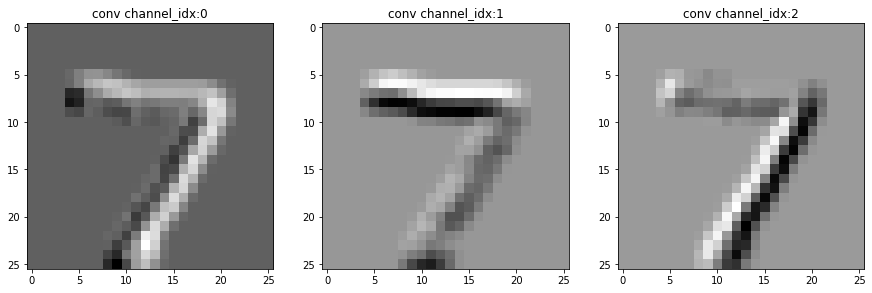

In [59]:
acts = model.forward_activations(img)
conv_acts = acts['conv']
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for i in range(3):
    axs[i].imshow(conv_acts[i].squeeze().detach().cpu(), cmap='gray')
    axs[i].set_title("conv channel_idx:" + str(i))
plt.show()

This matches what we expected! I'll try a different number

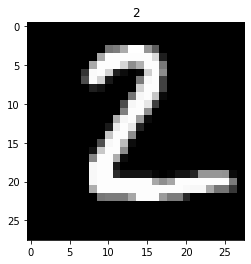

In [60]:
img, label = test_dataset[1]
img = img.to(device)
plt.imshow(img.squeeze().cpu(), cmap='gray')
plt.title(str(label));

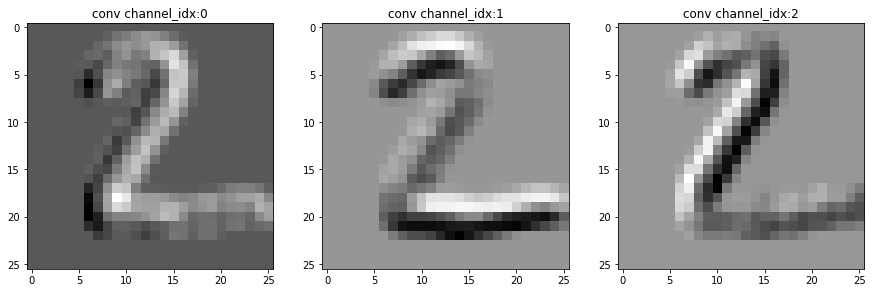

In [61]:
acts = model.forward_activations(img)
conv_acts = acts['conv']
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for i in range(3):
    axs[i].imshow(conv_acts[i].squeeze().detach().cpu(), cmap='gray')
    axs[i].set_title("conv channel_idx:" + str(i))
plt.show()

Still seems right, although more fuzzy here. I'll try one more

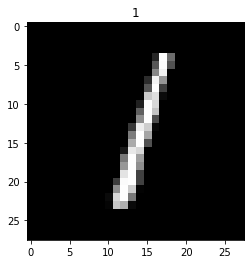

In [42]:
img, label = test_dataset[2]
img = img.to(device)
plt.imshow(img.squeeze().cpu(), cmap='gray')
plt.title(str(label));

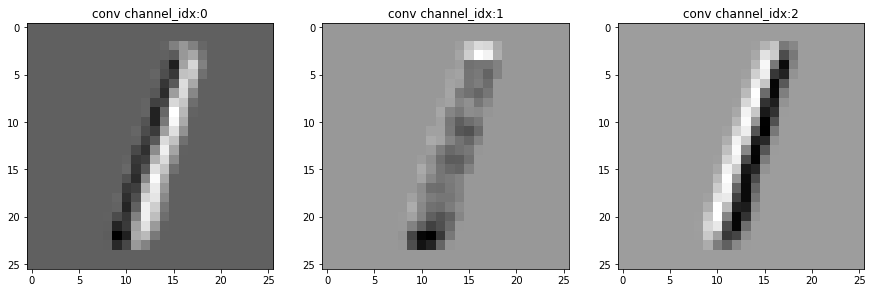

In [43]:
acts = model.forward_activations(img)
conv_acts = acts['conv']
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for i in range(3):
    axs[i].imshow(conv_acts[i].squeeze().detach().cpu(), cmap='gray')
    axs[i].set_title("conv channel_idx:" + str(i))
plt.show()

Looks right

I'll stop here. It might be more interesting to try the same techniques with a deeper cnn that can pick up more features before the fc layers. 